In [1]:
import math
import torch
from torch import nn
import numpy as np
from datasets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [3]:
# 读取数据
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set()
batch_size = 256
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()
my_gru = My_GRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)

In [4]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [5]:
from utils import *
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.3513, train rmse 673.9610, val loss 0.2296, val rmse 534.134760, time use 17.950s
*** epoch2, train loss 0.1463, train rmse 433.3824, val loss 0.0766, val rmse 293.332262, time use 17.109s
*** epoch3, train loss 0.0408, train rmse 226.6062, val loss 0.0178, val rmse 141.978559, time use 16.436s
*** epoch4, train loss 0.0112, train rmse 120.1817, val loss 0.0061, val rmse 86.576540, time use 17.220s
*** epoch5, train loss 0.0042, train rmse 73.4684, val loss 0.0022, val rmse 51.670250, time use 16.399s
*** epoch6, train loss 0.0016, train rmse 45.9451, val loss 0.0010, val rmse 34.726455, time use 16.291s
*** epoch7, train loss 0.0010, train rmse 35.2015, val loss 0.0008, val rmse 30.523851, time use 17.244s
*** epoch8, train loss 0.0008, train rmse 31.8550, val loss 0.0007, val rmse 28.938911, time use 16.846s
*** epoch9, train loss 0.0007, train rmse 30.4456, val loss 0.0007, val rmse 28.124656, time use 16.625s
*** epoch10, train loss 0.0007, train rmse 29.74

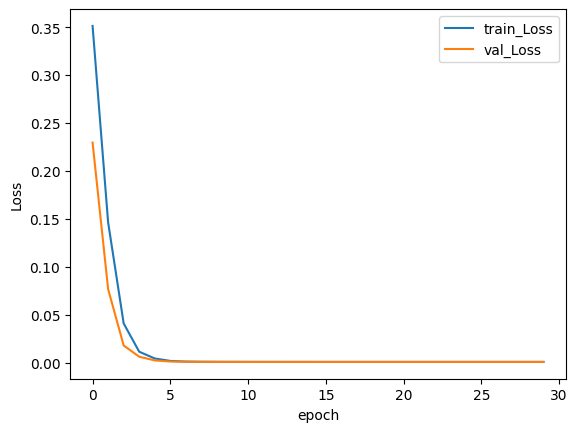

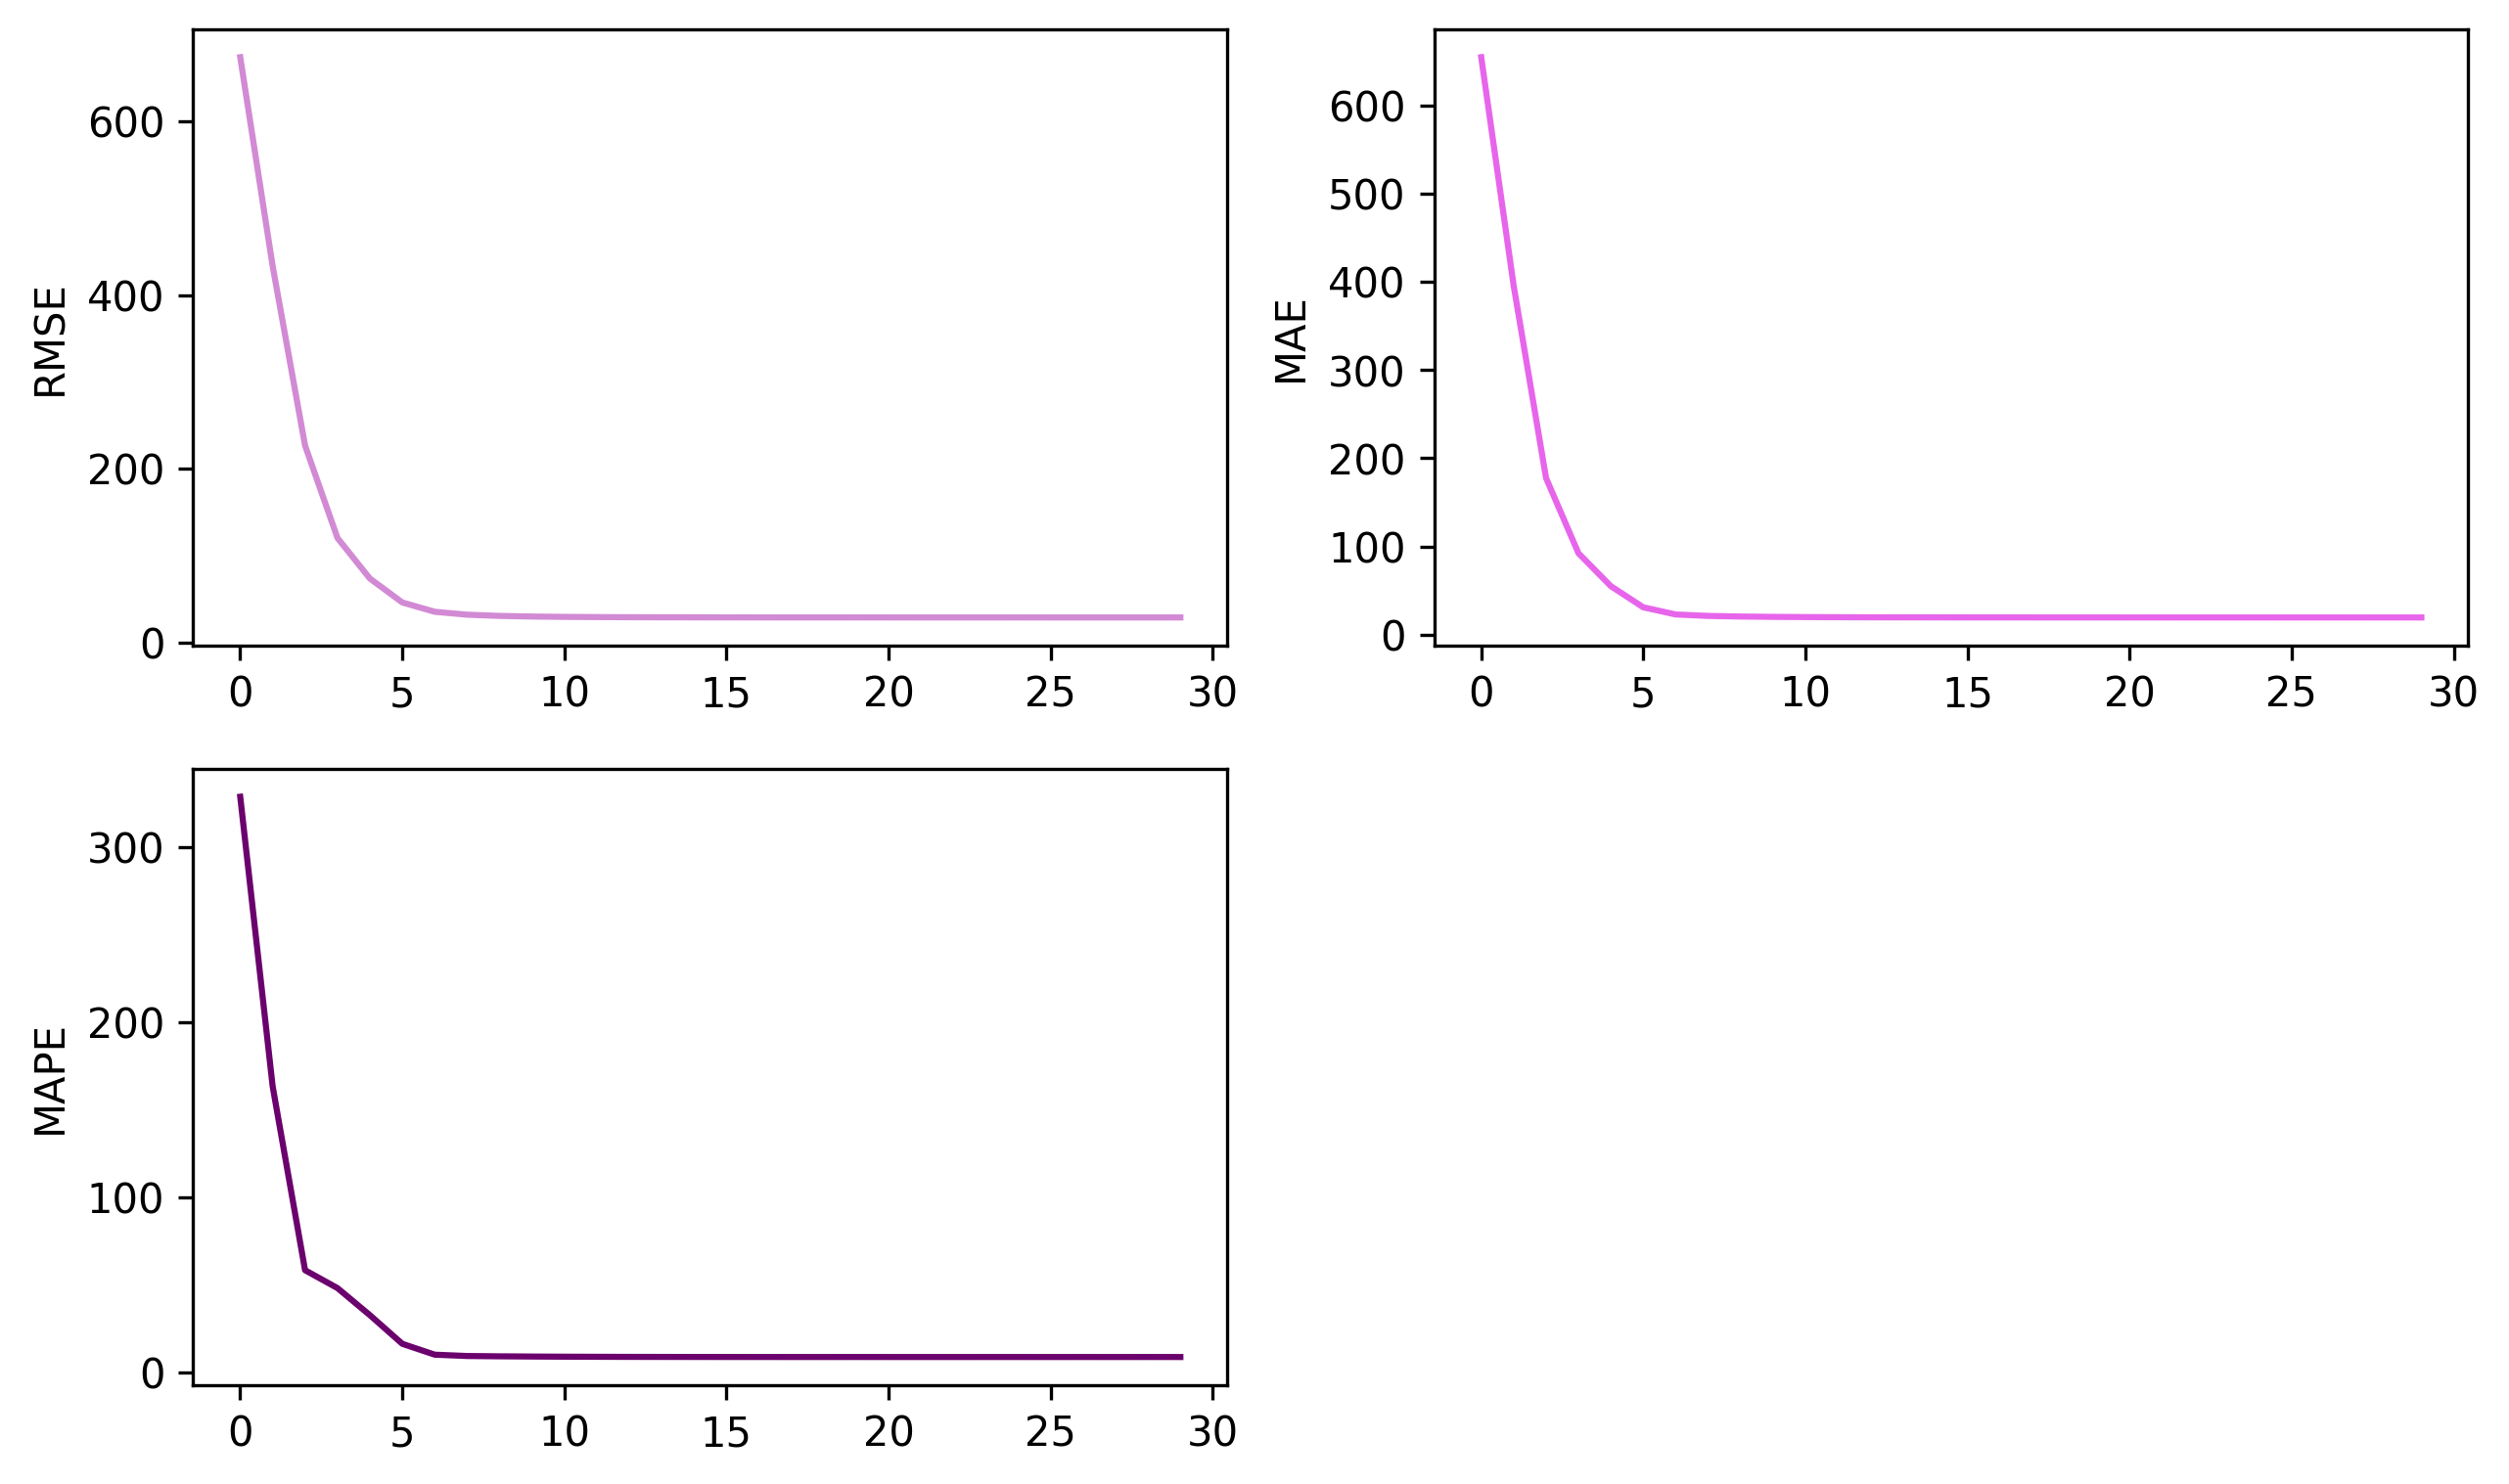

In [6]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [7]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
my_gru = My_GRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)
lr = 0.001 # 对比lr
hidden_size = 6 
my_gru = My_GRU(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_gru.parameters(), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=None)

*** epoch1, train loss 0.0129, train rmse 117.4550, val loss 0.0012, val rmse 37.572908, time use 16.648s
*** epoch2, train loss 0.0010, train rmse 35.2712, val loss 0.0009, val rmse 31.932254, time use 16.894s
*** epoch3, train loss 0.0008, train rmse 32.9278, val loss 0.0008, val rmse 30.249090, time use 16.089s
*** epoch4, train loss 0.0008, train rmse 31.4083, val loss 0.0007, val rmse 28.935325, time use 16.394s
*** epoch5, train loss 0.0007, train rmse 30.2891, val loss 0.0007, val rmse 28.134877, time use 16.364s
*** epoch6, train loss 0.0007, train rmse 29.5631, val loss 0.0006, val rmse 27.541634, time use 16.489s
*** epoch7, train loss 0.0007, train rmse 29.1108, val loss 0.0006, val rmse 27.232168, time use 16.877s
*** epoch8, train loss 0.0006, train rmse 28.9031, val loss 0.0006, val rmse 27.068484, time use 16.311s
*** epoch9, train loss 0.0006, train rmse 28.7883, val loss 0.0006, val rmse 27.001494, time use 16.713s
*** epoch10, train loss 0.0006, train rmse 28.7508, va

In [8]:
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 6
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 30
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0226, train rmse 171.0006, val loss 0.0157, val rmse 140.330295, time use 2.898s
*** epoch2, train loss 0.0140, train rmse 135.2456, val loss 0.0105, val rmse 115.158688, time use 2.545s
*** epoch3, train loss 0.0076, train rmse 99.0668, val loss 0.0036, val rmse 67.491888, time use 2.613s
*** epoch4, train loss 0.0015, train rmse 41.9485, val loss 0.0007, val rmse 28.074687, time use 2.806s
*** epoch5, train loss 0.0007, train rmse 29.6792, val loss 0.0007, val rmse 27.822869, time use 2.839s
*** epoch6, train loss 0.0007, train rmse 29.4504, val loss 0.0006, val rmse 27.627761, time use 2.762s
*** epoch7, train loss 0.0007, train rmse 29.2573, val loss 0.0006, val rmse 27.412518, time use 2.599s
*** epoch8, train loss 0.0007, train rmse 29.0993, val loss 0.0006, val rmse 27.267399, time use 2.645s
*** epoch9, train loss 0.0006, train rmse 28.9599, val loss 0.0006, val rmse 27.149783, time use 2.795s
*** epoch10, train loss 0.0006, train rmse 28.8459, val loss

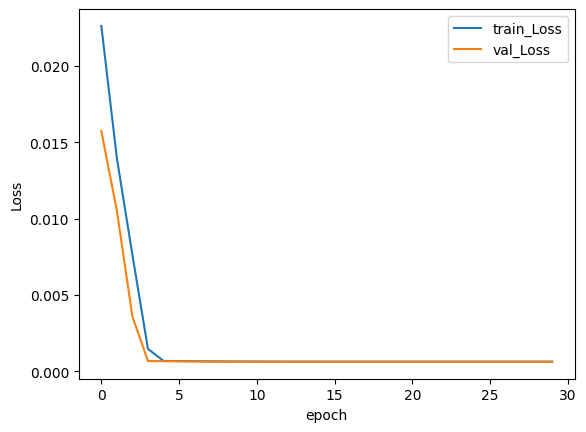

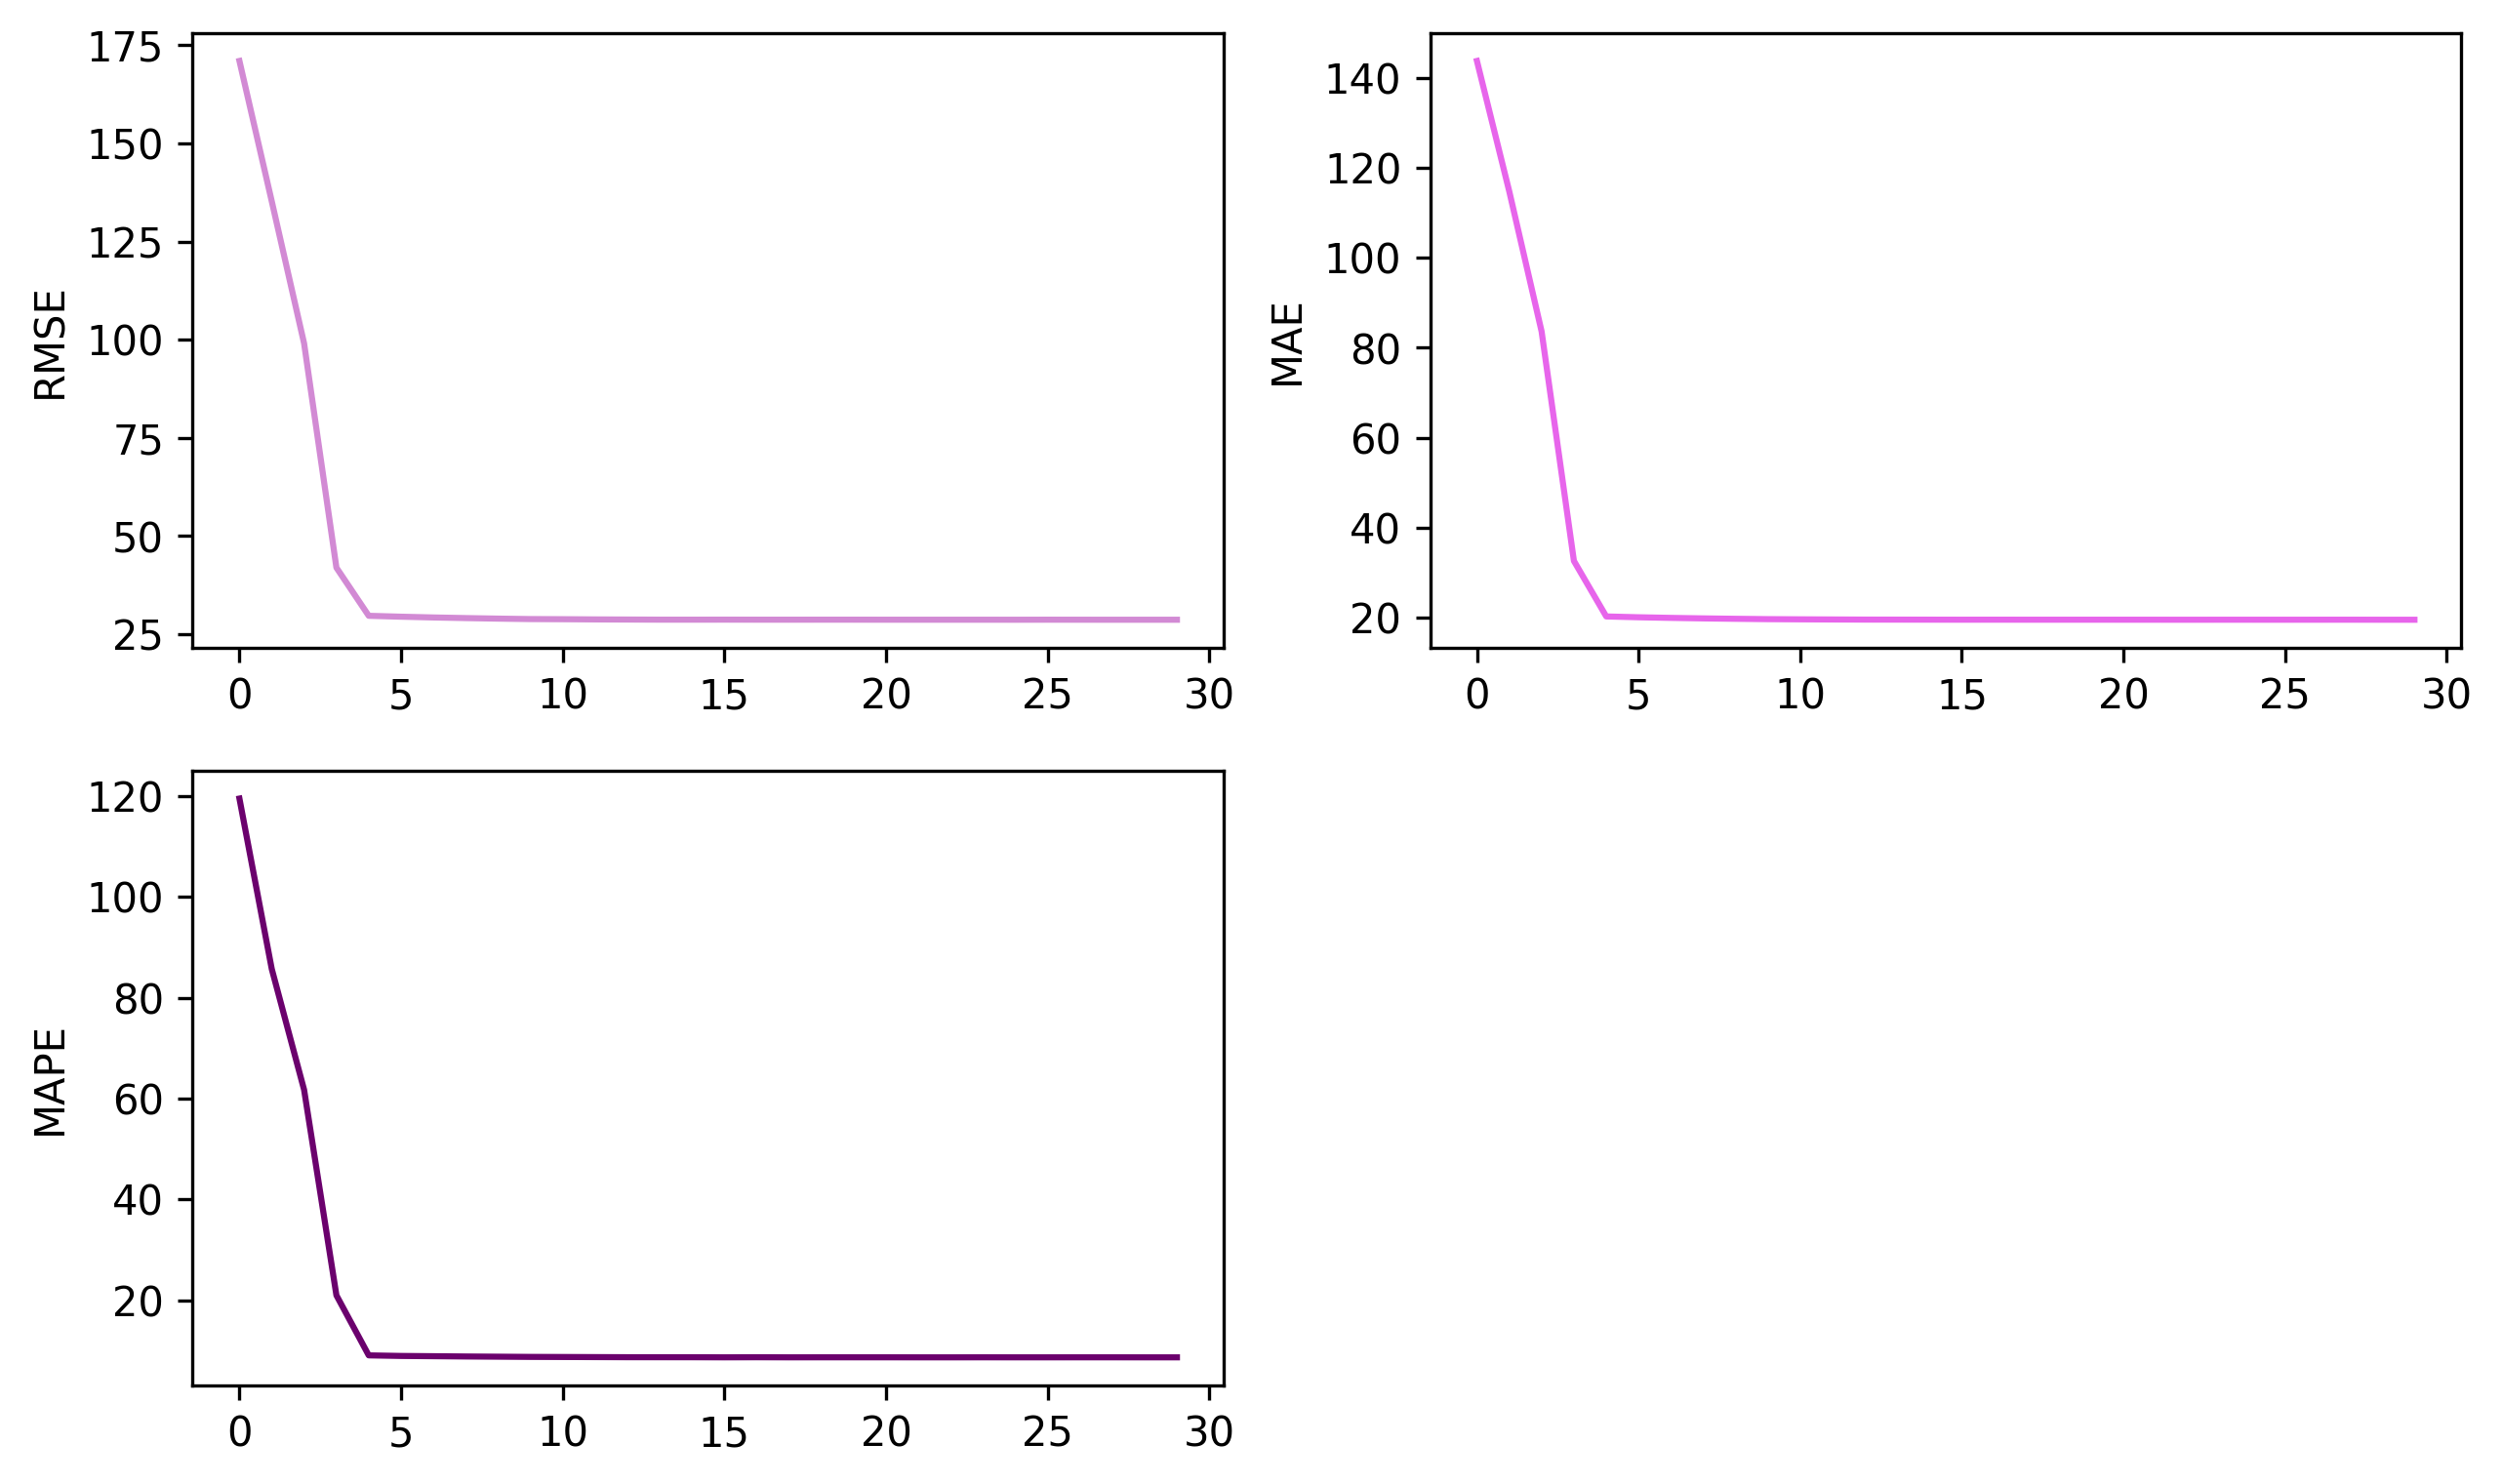

In [9]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [10]:
# 超参数对比
hidden_size = 16 # 对比hidden_size
nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)
hidden_size = 6
lr = 0.001 #对比lr
nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1), nn.LeakyReLU()).to(device)
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=10, device=device, output_model=out_linear)

*** epoch1, train loss 0.0252, train rmse 176.0823, val loss 0.0133, val rmse 129.414795, time use 2.912s
*** epoch2, train loss 0.0065, train rmse 85.6375, val loss 0.0009, val rmse 32.258779, time use 3.034s
*** epoch3, train loss 0.0009, train rmse 33.3462, val loss 0.0008, val rmse 30.793320, time use 2.943s
*** epoch4, train loss 0.0008, train rmse 32.3203, val loss 0.0008, val rmse 29.987572, time use 2.803s
*** epoch5, train loss 0.0008, train rmse 31.4441, val loss 0.0007, val rmse 29.106867, time use 2.824s
*** epoch6, train loss 0.0007, train rmse 30.6811, val loss 0.0007, val rmse 28.477968, time use 2.739s
*** epoch7, train loss 0.0007, train rmse 30.0762, val loss 0.0007, val rmse 28.002228, time use 2.732s
*** epoch8, train loss 0.0007, train rmse 29.6348, val loss 0.0007, val rmse 27.630078, time use 2.828s
*** epoch9, train loss 0.0007, train rmse 29.3050, val loss 0.0006, val rmse 27.445828, time use 2.947s
*** epoch10, train loss 0.0007, train rmse 29.0911, val loss 0